In [1]:
!which mpirun

/opt/intel/oneapi/mpi/2021.12/bin/mpirun


In [2]:
!seisflows

usage: seisflows [-h] [-w [WORKDIR]] [-p [PARAMETER_FILE]] [-v]
                 {init,configure,swap,submit,restart,clean,par,sempar,check,setup,plot2d,plotst,print,reset,debug,examples}
                 ...


                                SeisFlows v3.2.3                                


options:
  -h, --help            show this help message and exit
  -w [WORKDIR], --workdir [WORKDIR]
                        The SeisFlows working directory, default: cwd
  -p [PARAMETER_FILE], --parameter_file [PARAMETER_FILE]
                        Parameters file, default: 'parameters.yaml'
  -v, --version         Print out the current version of SeisFlows

command:
  Available SeisFlows arguments and their intended usages

    init                Runs SeisFlows first-time initiation procedures.
    configure           Fill parameter file with defaults
    swap                Swap module parameters in an existing parameter file
    submit              Submit initial workflow to system
    rest

In [3]:
pwd

'/csim1/zhangchang/testmodel2'

In [4]:
import os
import glob
import shutil
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import sys
import os
import datetime
import array
from util import *
import pathlib
import time

try:
    import obspy
except:
    print("Importing obspy failed, please install obspy: pip install -U obspy")
    sys.exit(1)

from scipy.ndimage import gaussian_filter
from scipy.interpolate import RectBivariateSpline   # replaces: interp2d
from seisflows.tools.unix import cd, cp, rm, ln, mv, mkdir
from seisflows.seisflows import SeisFlows
from seisflows.tools.config import import_seisflows
from seisflows.tools.model import Model
from plot_2d_image import plot_2d_image
from seisflows.workflow.WD_inversion import norm_trace

In [5]:
model_list = sio.loadmat('topo60m.mat')
topo = -model_list['topo3'].astype('float32').T+60

data = np.concatenate((np.arange(1,181).reshape(-1,1),topo),axis=1)
lentopo = np.max(data.shape)
lentopo
f = open("interface1.dat", "w")
f.write(f"# number of interfaces\n")
f.write(f"{2}\n")
f.write(f"# for each interface below, we give the number of points and then x,z for each point\n")
f.write(f"# interface number 1 (bottom of the mesh)\n")
f.write(f"{2}\n")
f.write(f"{1} {1}\n")
f.write(f"{180} {1}\n")
f.write(f"# interface number 2 (top)\n")
f.write(f"{lentopo}\n")
for i in range(lentopo):
    f.write(f"{data[i,0]}   {data[i,1]}\n")
f.write(f"# for each layer, we give the number of spectral elements in the vertical direction\n")
f.write(f"# layer number\n")
f.write(f"{15}\n")
f.close()

In [6]:
model_list = sio.loadmat('modeltest2.mat')
## model
# model_list = sio.loadmat('layer_model.mat')
# model_list = sio.loadmat('testtopomodel.mat')
vp = model_list['vp'].astype('float32').T
vs = model_list['vs'].astype('float32').T
vp_init = model_list['vp_init'].astype('float32').T
vp = vp_init
vs_init = model_list['vs_init'].astype('float32').T
# vs_init = vs
filename_true_out = os.path.join(os.getcwd(), "test_model_true.xyz")
filename_init_out = os.path.join(os.getcwd(), "test_model_init.xyz")
use_tomography_file_ascii_format=1
# vs_init = vs
density = 310*vp**(1/4)

## Observation systems
dx=1
dz=1
[nx,nz]=vp.shape
nt=5000
fr=30.0             
ds=6
sx=np.arange(0,nx,ds)+1.0

# sz = topo[sx.astype(int)] - 1 
# sz = sz.squeeze()
sz=np.zeros(sx.shape)+nz - 1 

ns=len(sx)
dg=2
gx=np.arange(0,nx,dg)+1.0

# gz = topo[gx.astype(int)] - 1 
# gz = gz.squeeze()
gz=np.zeros(gx.shape)+nz - 1
ng=len(gx)

## dt dx
max_dx = np.min(vs)/70
dx_1=4
dt=0.3*dx_1/5/np.max(vp)
# dt=8e-5
dt=1e-4
print('max_dx',max_dx)

max_dx 6.882513863699777


In [7]:
f = open("STATIONS-copy", "w")
for i in range(ng):
    s = "%04d" % int(i+1)
    f.write(f"S{s}    AA            {gx[i]}           {gz[i]}       0.0         0.0\n")
f.close()

    vp  min/max =   963.55 /  1885.32 (m/s)
    vs  min/max =   481.78 /   942.66 (m/s)
    rho min/max =  1727.15 /  2042.72 (kg/m^3)

  grid: x     range min/max = 0.00 / 179.00 (m)
        depth range min/max = 0.00 / 59.00 (m)
        nx / nz             = 180 / 60
        dx / dz             = 1.00 / 1.00 (m)

        resolved maximum frequency =  96.35519409179688

  plotted as  vp.jpg

    vp  min/max =   963.55 /  1885.32 (m/s)
    vs  min/max =   481.78 /   942.66 (m/s)
    rho min/max =  1727.15 /  2042.72 (kg/m^3)

  grid: x     range min/max = 0.00 / 179.00 (m)
        depth range min/max = 0.00 / 59.00 (m)
        nx / nz             = 180 / 60
        dx / dz             = 1.00 / 1.00 (m)

        resolved maximum frequency =  96.35519409179688

  plotted as  vp.jpg

creating tomography file:
  dimension:
    nx / nz = 180 / 60
    dx / dz = 1 / 1 (m)
    x origin / end = 0.0 / 179.0 (m)
    z origin / end = 0.0 / 59.0 (m)

  tomographic model statistics:
    vp  min/max 

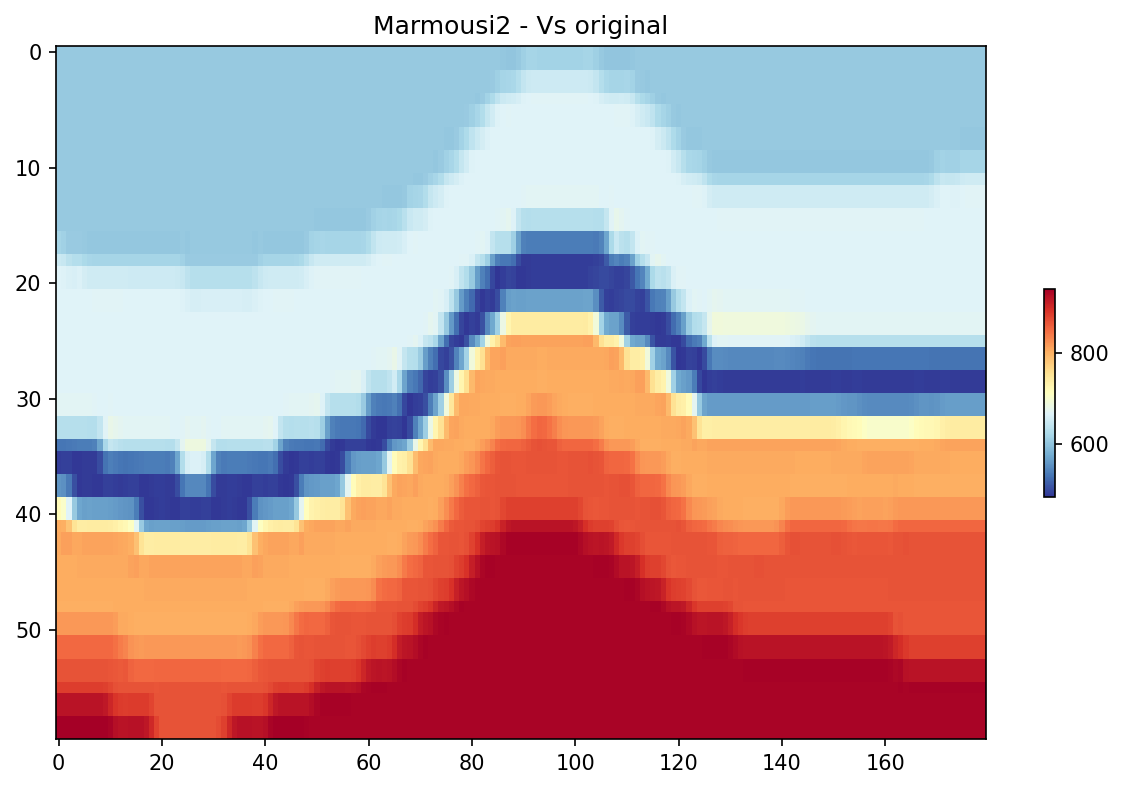

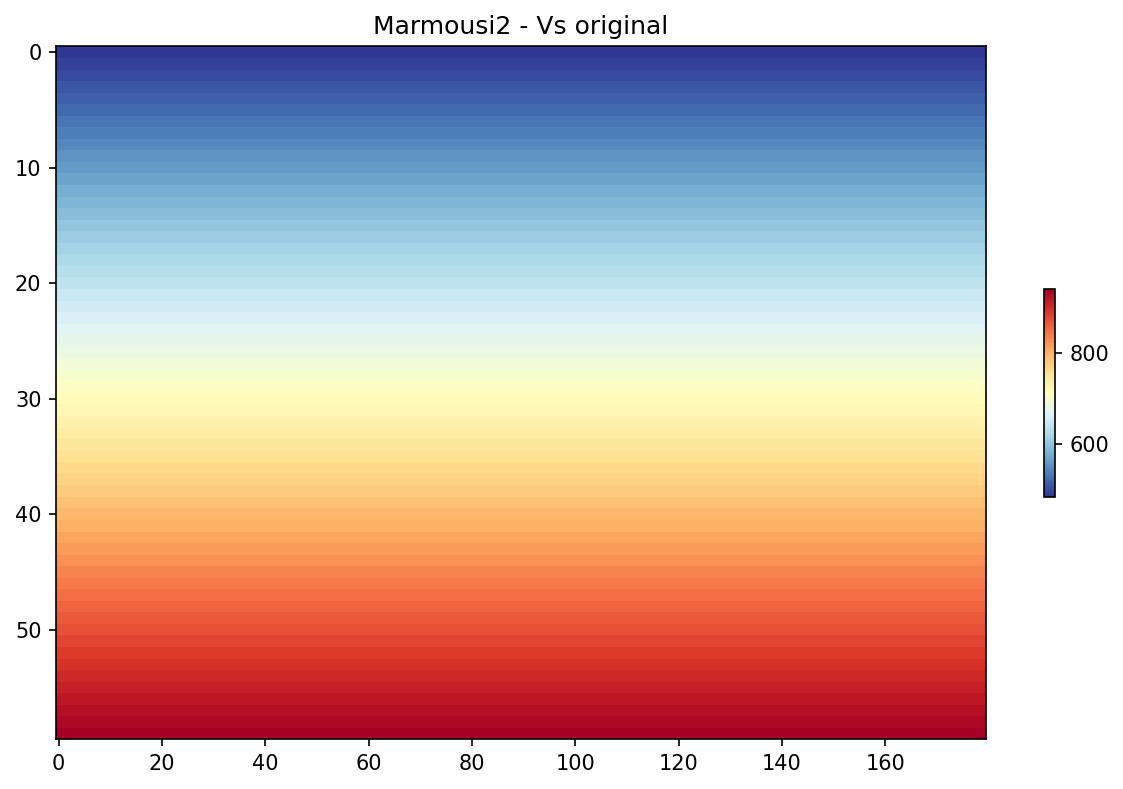

In [8]:
model_true = matmodel2specfem(vp,vs,density,dx,dz)
model_init = matmodel2specfem(vp_init,vs_init,density,dx,dz)
create_tomography_file(model_true,filename_true_out,use_tomography_file_ascii_format)
create_tomography_file(model_init,filename_init_out,use_tomography_file_ascii_format)

In [9]:
# vvv USER MUST EDIT THE FOLLOWING PATHS vvv
WORKDIR = os.getcwd()
SPECFEM2D = "/csim1/zhangchang/specfem2d"
# where WORKDIR: points to your own working directory
# and SPECFEM2D: points to an existing specfem2D repository if available (if not set as '')
# ^^^ USER MUST EDIT THE FOLLOWING PATHS ^^^
# ======================================================================================================

# Distribute the necessary file structure of the SPECFEM2D repository that we will downloaded/reference
SPECFEM2D_ORIGINAL = os.path.join(WORKDIR, "specfem2d")
SPECFEM2D_BIN_ORIGINAL = os.path.join(SPECFEM2D_ORIGINAL, "bin")
SPECFEM2D_DATA_ORIGINAL = os.path.join(SPECFEM2D_ORIGINAL, "DATA")

# The SPECFEM2D working directory that we will create separate from the downloaded repo
SPECFEM2D_WORKDIR = os.path.join(WORKDIR, "specfem2d_workdir")
SPECFEM2D_BIN = os.path.join(SPECFEM2D_WORKDIR, "bin")
SPECFEM2D_DATA = os.path.join(SPECFEM2D_WORKDIR, "DATA")
SPECFEM2D_OUTPUT = os.path.join(SPECFEM2D_WORKDIR, "OUTPUT_FILES")

# Pre-defined locations of velocity models we will generate using the solver
SPECFEM2D_MODEL_INIT = os.path.join(SPECFEM2D_WORKDIR, "OUTPUT_FILES_INIT")
SPECFEM2D_MODEL_TRUE = os.path.join(SPECFEM2D_WORKDIR, "OUTPUT_FILES_TRUE")
# Download SPECFEM2D from GitHub, devel branch for latest codebase OR symlink from existing repo
if not os.path.exists(WORKDIR):
    os.makedirs(WORKDIR)
os.chdir(WORKDIR)

if os.path.exists("specfem2d"):
    print("SPECFEM2D repository already found, you may skip this subsection")
    pass
elif os.path.exists(SPECFEM2D):
    print("Existing SPECMFE2D respository found, symlinking to working directory")
    os.symlink(SPECFEM2D, "./specfem2d")
else:
    print("Cloning respository from GitHub")
    ! git clone --recursive --branch devel https://github.com/geodynamics/specfem2d.git
# Compile SPECFEM2D to generate the Makefile
os.chdir(SPECFEM2D_ORIGINAL)
if not os.path.exists("./config.log"):
    os.system("./configure")
# Run make to generate SPECFEM2D binaries
if not os.path.exists("bin"):
    os.system("make all")
# Check out the binary files that have been created
os.chdir(SPECFEM2D_ORIGINAL)
# Incase we've run this docs page before, delete the working directory before remaking
if os.path.exists(SPECFEM2D_WORKDIR):
    shutil.rmtree(SPECFEM2D_WORKDIR)

os.mkdir(SPECFEM2D_WORKDIR)
os.chdir(SPECFEM2D_WORKDIR)

# Copy the binary files incase we update the source code. These can also be symlinked.
shutil.copytree(SPECFEM2D_BIN_ORIGINAL, "bin")

if not os.path.exists(SPECFEM2D_DATA):
    os.makedirs(SPECFEM2D_DATA)
OUTPUT_path = os.path.join(WORKDIR, "output")

SPECFEM2D repository already found, you may skip this subsection


In [10]:
##source file
os.chdir(SPECFEM2D_DATA)
for i in range(ns):
    i=i+1
    print('num source',i)
    froms = WORKDIR + '/SOURCE-Copy1'
    if i<10:
        SOURCEN = 'SOURCE_00' + str(i)
    else:
        SOURCEN = 'SOURCE_0' + str(i)
    pathSOURCEN = './' + SOURCEN
    cp(froms, pathSOURCEN)
    os.system('seisflows sempar f0 ' + str(fr) + ' -P ' + SOURCEN)
    os.system('seisflows sempar xs ' + str(sx[i-1]) + ' -P ' + SOURCEN)
    os.system('seisflows sempar zs ' + str(sz[i-1]) + ' -P ' + SOURCEN)
!ls

num source 1
f0: 30.0 -> 30.0
xs: 0. -> 1.0
zs: 0. -> 59.0
num source 2
f0: 30.0 -> 30.0
xs: 0. -> 7.0
zs: 0. -> 59.0
num source 3
f0: 30.0 -> 30.0
xs: 0. -> 13.0
zs: 0. -> 59.0
num source 4
f0: 30.0 -> 30.0
xs: 0. -> 19.0
zs: 0. -> 59.0
num source 5
f0: 30.0 -> 30.0
xs: 0. -> 25.0
zs: 0. -> 59.0
num source 6
f0: 30.0 -> 30.0
xs: 0. -> 31.0
zs: 0. -> 59.0
num source 7
f0: 30.0 -> 30.0
xs: 0. -> 37.0
zs: 0. -> 59.0
num source 8
f0: 30.0 -> 30.0
xs: 0. -> 43.0
zs: 0. -> 59.0
num source 9
f0: 30.0 -> 30.0
xs: 0. -> 49.0
zs: 0. -> 59.0
num source 10
f0: 30.0 -> 30.0
xs: 0. -> 55.0
zs: 0. -> 59.0
num source 11
f0: 30.0 -> 30.0
xs: 0. -> 61.0
zs: 0. -> 59.0
num source 12
f0: 30.0 -> 30.0
xs: 0. -> 67.0
zs: 0. -> 59.0
num source 13
f0: 30.0 -> 30.0
xs: 0. -> 73.0
zs: 0. -> 59.0
num source 14
f0: 30.0 -> 30.0
xs: 0. -> 79.0
zs: 0. -> 59.0
num source 15
f0: 30.0 -> 30.0
xs: 0. -> 85.0
zs: 0. -> 59.0
num source 16
f0: 30.0 -> 30.0
xs: 0. -> 91.0
zs: 0. -> 59.0
num source 17
f0: 30.0 -> 30.0
xs: 

In [11]:
froms = WORKDIR + '/Par_file-Copy1'
SOURCEN = 'Par_file'
pathSOURCEN = './' + SOURCEN
cp(froms, pathSOURCEN)
froms = WORKDIR + '/interfaces-Copy1.dat'
# froms = WORKDIR + '/interface1.dat'
SOURCEN = 'interfaces.dat'
pathinterface = './' + SOURCEN
cp(froms, pathinterface)
froms = WORKDIR + '/STATIONS-copy'
SOURCEN = 'STATIONS'
pathSTATIONS = './' + SOURCEN
cp(froms, pathSTATIONS)
!ls

interfaces.dat	SOURCE_005  SOURCE_011	SOURCE_017  SOURCE_023	SOURCE_029
Par_file	SOURCE_006  SOURCE_012	SOURCE_018  SOURCE_024	SOURCE_030
SOURCE_001	SOURCE_007  SOURCE_013	SOURCE_019  SOURCE_025	STATIONS
SOURCE_002	SOURCE_008  SOURCE_014	SOURCE_020  SOURCE_026
SOURCE_003	SOURCE_009  SOURCE_015	SOURCE_021  SOURCE_027
SOURCE_004	SOURCE_010  SOURCE_016	SOURCE_022  SOURCE_028


In [12]:
os.system('seisflows sempar NSTEP ' + str(nt))
os.system('seisflows sempar DT ' + str(dt))
os.system('seisflows sempar TOMOGRAPHY_FILE ' + filename_true_out)
os.system('seisflows sempar seismotype ' + str(1))
os.system('seisflows sempar nrec ' + str(ng))
os.system('seisflows sempar xdeb ' + str(gx[0]))
os.system('seisflows sempar zdeb ' + str(gz[0]))
os.system('seisflows sempar xfin ' + str(gx[-1]))
os.system('seisflows sempar zfin ' + str(gz[-1]))
os.system('seisflows sempar interfacesfile ' + pathinterface)
os.system('seisflows sempar xmin ' + '0.d0')
os.system('seisflows sempar xmax ' + str(nx-1) + '.d0')
os.system('seisflows sempar nx ' + str(nx/4))
os.system('seisflows sempar NPROC ' + str(1))

NSTEP: 5000 -> 5000
DT: 0.0001 -> 0.0001
TOMOGRAPHY_FILE: /home/user/CSIM3/chq/modeltest/test_model_true.xyz ->
/csim1/zhangchang/testmodel2/test_model_true.xyz
seismotype: 1 -> 1
nrec: 10 -> 90
xdeb: 1.0 -> 1.0
zdeb: 59.0 -> 59.0
xfin: 179.0 -> 179.0
zfin: 59.0 -> 59.0
interfacesfile: ./interfaces.dat -> ./interfaces.dat
xmin: 1.0 -> 0.d0
xmax: 180.0 -> 179.d0
nx: 45 -> 45.0
NPROC: 1 -> 1


0

In [13]:
# First we will set the correct SOURCE and STATION files.
# This is the same task as shown in ./run_this_example.sh
os.chdir(SPECFEM2D_DATA)

# Symlink source 001 as our main source
if os.path.exists("SOURCE"):
    os.remove("SOURCE")
os.symlink("SOURCE_001", "SOURCE")
!ls

interfaces.dat	SOURCE_004  SOURCE_010	SOURCE_016  SOURCE_022	SOURCE_028
Par_file	SOURCE_005  SOURCE_011	SOURCE_017  SOURCE_023	SOURCE_029
SOURCE		SOURCE_006  SOURCE_012	SOURCE_018  SOURCE_024	SOURCE_030
SOURCE_001	SOURCE_007  SOURCE_013	SOURCE_019  SOURCE_025	STATIONS
SOURCE_002	SOURCE_008  SOURCE_014	SOURCE_020  SOURCE_026
SOURCE_003	SOURCE_009  SOURCE_015	SOURCE_021  SOURCE_027


In [14]:
# os.chdir(SPECFEM2D_DATA)

# Ensure that SPECFEM2D outputs the velocity model in the expected binary format
!seisflows sempar setup_with_binary_database 1  # allow creation of .bin files
!seisflows sempar save_model binary  # output model in .bin database format
!seisflows sempar save_ascii_kernels .false.  # output kernels in .bin format, not ASCII

setup_with_binary_database: 1 -> 1
SAVE_MODEL: binary -> binary
save_ASCII_kernels: .false. -> .false.


In [15]:
# GENERATE MODEL_TRUE
os.chdir(SPECFEM2D_DATA)

# Edit the Par_file by increasing velocities by ~10%
os.system('seisflows sempar TOMOGRAPHY_FILE ' + filename_init_out)

TOMOGRAPHY_FILE: /csim1/zhangchang/testmodel2/test_model_true.xyz ->
/csim1/zhangchang/testmodel2/test_model_init.xyz


0

In [16]:
# SPECFEM requires that we create the OUTPUT_FILES directory before running
os.chdir(SPECFEM2D_WORKDIR)

if os.path.exists(SPECFEM2D_OUTPUT):
    shutil.rmtree(SPECFEM2D_OUTPUT)

os.mkdir(SPECFEM2D_OUTPUT)

!ls

bin  DATA  OUTPUT_FILES


In [17]:
!which mpirun

/opt/intel/oneapi/mpi/2021.12/bin/mpirun


In [18]:
# GENERATE MODEL_INIT
os.chdir(SPECFEM2D_WORKDIR)

# Run the mesher and solver to generate our initial model
!./bin/xmeshfem2D > OUTPUT_FILES/mesher_log.txt
!./bin/xspecfem2D > OUTPUT_FILES/solver_log.txt
# GENERATE MODEL_TRUE
# os.chdir(SPECFEM2D_DATA)

# # Edit the Par_file by increasing velocities by ~10%
# os.system('seisflows sempar TOMOGRAPHY_FILE ' + "")
# os.chdir(SPECFEM2D_WORKDIR)
# Move the model files (*.bin) into the OUTPUT_FILES directory, where SeisFlows3 expects them
!mv DATA/*bin OUTPUT_FILES

# Make sure we don't overwrite this initial model when creating our target model in the next step
!mv OUTPUT_FILES OUTPUT_FILES_INIT

!head OUTPUT_FILES_INIT/solver_log.txt
!tail OUTPUT_FILES_INIT/solver_log.txt

 
 **********************************************
 **** Specfem 2-D Solver - MPI version     ****
 **********************************************
 
 Running Git version of the code corresponding to 
 e70c9c88e5f0a1edc64870c514ef52d08e5d1ef0
 dating 2024-06-05 17:41:24 +0200
 
 There are            1  MPI processes
 -------------------------------------------------------------------------------
 Program SPECFEM2D: 
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 model test
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 D a t e : 22 - 07 - 2024                                 T i m e  : 22:18:48
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------


In [19]:
# import numpy as np
# from scipy.interpolate import RegularGridInterpolator

# vp_con = np.concatenate((963.55194*np.ones((10,180)),vp_init.T),axis=0)
# vs_con = np.concatenate((481.77597*np.ones((10,180)),vs_init.T),axis=0)
# vs_con.shape

# temp_model = Model(os.path.join("OUTPUT_FILES_INIT"))
# # 创建要插值的数据点
# x1 = np.arange(0,180,1)
# # z1 = np.arange(0,60,1)
# z1 = np.linspace(70,1,70)
# # 创建插值函数
# interp_func_vp = RegularGridInterpolator((z1, x1), vp_con)
# interp_func_vs = RegularGridInterpolator((z1, x1), vs_con)
# # 定义要插值的点
# coord_x = temp_model.coordinates['x'].astype('float32')
# coord_z = temp_model.coordinates['z'].astype('float32')
# points = np.concatenate((coord_z,coord_x),axis=0).T
# # points = np.array([[0.0, 0.0], [59.0, 179.]])
# # # 进行插值
# interp_values_vp = interp_func_vp(points).reshape((1,-1))
# interp_values_vs = interp_func_vs(points).reshape((1,-1))

# temp_model.model['vp'] = interp_values_vp
# temp_model.model['vs'] = interp_values_vs
# temp_model.merge()
# temp_model.write(os.path.join("OUTPUT_FILES_INIT"))

In [20]:
pwd

'/csim1/zhangchang/testmodel2/specfem2d_workdir'

In [21]:
# GENERATE MODEL_TRUE
os.chdir(SPECFEM2D_DATA)

# Edit the Par_file by increasing velocities by ~10%
os.system('seisflows sempar TOMOGRAPHY_FILE ' + filename_true_out)

TOMOGRAPHY_FILE: /csim1/zhangchang/testmodel2/test_model_init.xyz ->
/csim1/zhangchang/testmodel2/test_model_true.xyz


0

In [22]:
# SPECFEM requires that we create the OUTPUT_FILES directory before running
os.chdir(SPECFEM2D_WORKDIR)

if os.path.exists(SPECFEM2D_OUTPUT):
    shutil.rmtree(SPECFEM2D_OUTPUT)

os.mkdir(SPECFEM2D_OUTPUT)

!ls

bin  DATA  OUTPUT_FILES  OUTPUT_FILES_INIT


In [23]:
# GENERATE MODEL_TRUE
os.chdir(SPECFEM2D_WORKDIR)

# Run the mesher and solver to generate our initial model
!./bin/xmeshfem2D > OUTPUT_FILES/mesher_log.txt
!./bin/xspecfem2D > OUTPUT_FILES/solver_log.txt
# os.chdir(SPECFEM2D_DATA)

# # Edit the Par_file by increasing velocities by ~10%
# os.system('seisflows sempar TOMOGRAPHY_FILE ' + "")
# os.chdir(SPECFEM2D_WORKDIR)
# Move the model files (*.bin) into the OUTPUT_FILES directory, where SeisFlows3 expects them
!mv DATA/*bin OUTPUT_FILES

# Make sure we don't overwrite this initial model when creating our target model in the next step
!mv OUTPUT_FILES OUTPUT_FILES_TRUE

!head OUTPUT_FILES_TRUE/solver_log.txt
!tail OUTPUT_FILES_TRUE/solver_log.txt

 
 **********************************************
 **** Specfem 2-D Solver - MPI version     ****
 **********************************************
 
 Running Git version of the code corresponding to 
 e70c9c88e5f0a1edc64870c514ef52d08e5d1ef0
 dating 2024-06-05 17:41:24 +0200
 
 There are            1  MPI processes
 -------------------------------------------------------------------------------
 Program SPECFEM2D: 
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 model test
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 D a t e : 22 - 07 - 2024                                 T i m e  : 22:18:57
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------


In [24]:
# import numpy as np
# from scipy.interpolate import RegularGridInterpolator

# vp_con = np.concatenate((1.044e+03*np.ones((10,180)),vp.T),axis=0)
# vs_con = np.concatenate((603*np.ones((10,180)),vs.T),axis=0)
# vs_con.shape

# temp_model = Model(os.path.join("OUTPUT_FILES_TRUE"))
# # 创建要插值的数据点
# x1 = np.arange(0,180,1)
# # z1 = np.arange(0,60,1)
# z1 = np.linspace(70,1,70)
# # 创建插值函数
# interp_func_vp = RegularGridInterpolator((z1, x1), vp_con)
# interp_func_vs = RegularGridInterpolator((z1, x1), vs_con)
# # 定义要插值的点
# coord_x = temp_model.coordinates['x'].astype('float32')
# coord_z = temp_model.coordinates['z'].astype('float32')
# points = np.concatenate((coord_z,coord_x),axis=0).T
# # points = np.array([[0.0, 0.0], [59.0, 179.]])
# # # 进行插值
# interp_values_vp = interp_func_vp(points).reshape((1,-1))
# interp_values_vs = interp_func_vs(points).reshape((1,-1))

# temp_model.model['vp'] = interp_values_vp
# temp_model.model['vs'] = interp_values_vs
# temp_model.merge()
# temp_model.write(os.path.join("OUTPUT_FILES_TRUE"))

In [25]:
!ls

bin  DATA  OUTPUT_FILES_INIT  OUTPUT_FILES_TRUE


In [26]:
WORKDIR

'/csim1/zhangchang/testmodel2'

In [27]:
# The command 'setup' creates the 'parameters.yaml' file that controls all of SeisFlows
# the '-f' flag removes any exist 'parameters.yaml' file that might be in the directory
os.chdir(WORKDIR)
# !seisflows init 
!ls

DATA			specfem_trace_layermodel.mat
interface1.dat		specfem_trace_layermodel_surface2.mat
interfaces-Copy1.dat	specfem_trace_layermodel_surface.mat
layer_model.mat		specfem_trace.mat
modeltest2.mat		STATIONS-copy
output.txt		test.ipynb
parameters.yaml		test_model_init.xyz
Par_file-Copy1		testmodel.mat
plot_2d_image.py	test_model_true.xyz
__pycache__		testtopomodel.mat
simpleWDdisp.mat	topo60m.mat
SOURCE-Copy1		untitled.txt
specfem2d		util.py
specfem2d_workdir	vp.jpg
specfem_pretest2.ipynb


In [28]:
os.chdir(SPECFEM2D_DATA)
!seisflows sempar model gll
!seisflows sempar velocity_model '1 1 1960.d0 1600.d0 800.0d0 0 0 9999 9999 0 0 0 0 0 0'
#           #       #model_number 1 rho Vp Vs k 0 QKappa Qmu 0 0 0 0 0 0

MODEL: default -> gll
Traceback (most recent call last):
  File "/home/zhangchang/miniconda3/envs/seisflow_devel/bin/seisflows", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/csim1/zhangchang/seisflow_devel/seisflows/seisflows.py", line 1456, in main
    sf()
  File "/csim1/zhangchang/seisflow_devel/seisflows/seisflows.py", line 456, in __call__
    getattr(self, self._args.command)(**vars(self._args))
  File "/csim1/zhangchang/seisflow_devel/seisflows/seisflows.py", line 972, in sempar
    setpar_vel_model(file=par_file, model=value.split("+"))
  File "/csim1/zhangchang/seisflow_devel/seisflows/tools/specfem.py", line 620, in setpar_vel_model
    model_idx_start = model_lines[0]
                      ~~~~~~~~~~~^^^
IndexError: list index out of range


In [29]:
os.chdir(WORKDIR)

In [24]:
!seisflows par workflow WD_inversion
!seisflows par system cluster
!seisflows configure

workflow: WD_inversion -> inversion
system: workstation -> cluster
configuring SeisFlows parameter file
error: parameter file has already been configured, either create a new file with 'setup' or swap modules with 'swap'


In [37]:
# EDIT THE SEISFLOWS PARAMETER FILE
!seisflows par ntask 30  # set the number of sources/events to use
!seisflows par materials elastic  # update Vp and Vs during inversion
!seisflows par end 1000  # final iteration -- we will only run 1
# !seisflows par data_case synthetic  # synthetic-synthetic means we need both INIT and TRUE models
# !seisflows par step_count_max 5  # limit the number of steps in the line search
!seisflows par unit_output DISP  
!seisflows par generate_data True 
!seisflows par ntask_max 30
# Use Python syntax here to access path constants
os.system(f"seisflows par path_specfem_bin {SPECFEM2D_BIN}")  # set path to SPECFEM2D binaries
os.system(f"seisflows par path_specfem_data {SPECFEM2D_DATA}")  # set path to SEPCFEM2D DATA/
os.system(f"seisflows par path_model_init {SPECFEM2D_MODEL_INIT}")  # set path to INIT model
os.system(f"seisflows par path_model_true {SPECFEM2D_MODEL_TRUE}")  # set path to TRUE model

ntask: 30 -> 50
materials: elastic -> elastic
end: 1000 -> 1000
unit_output: DISP -> DISP
generate_data: True -> True
ntask_max: 30 -> 50
path_specfem_bin: /csim1/zhangchang/testmodel2/specfem2d_workdir/bin ->
/csim1/zhangchang/testmodel2/specfem2d_workdir/bin
path_specfem_data: /csim1/zhangchang/testmodel2/specfem2d_workdir/DATA ->
/csim1/zhangchang/testmodel2/specfem2d_workdir/DATA
path_model_init:
/csim1/zhangchang/testmodel2/specfem2d_workdir/OUTPUT_FILES_INIT ->
/csim1/zhangchang/testmodel2/specfem2d_workdir/OUTPUT_FILES_INIT
path_model_true:
/csim1/zhangchang/testmodel2/specfem2d_workdir/OUTPUT_FILES_TRUE ->
/csim1/zhangchang/testmodel2/specfem2d_workdir/OUTPUT_FILES_TRUE


0

NameError: name 'os' is not defined

In [31]:
SPECFEM2D_DATA

'/csim1/zhangchang/testmodel2/specfem2d_workdir/DATA'

In [32]:
WORKDIR

'/csim1/zhangchang/testmodel2'

In [40]:
os.chdir(WORKDIR)
# !seisflows print tasks

In [55]:
gradient.parameters

['Hessian1_kernel', 'Hessian2_kernel', 'vp_kernel', 'vs_kernel']

In [135]:
misfit_kernel_path = '/csim1/zhangchang/testmodel2/scratch/eval_grad/misfit_kernel'
gradient = Model(path=misfit_kernel_path,parameters=['vp_kernel','vs_kernel','Hessian1_kernel', 'Hessian2_kernel'])
# gradient.parameters = ['Hessian1_kernel', 'Hessian2_kernel', 'vp_kernel', 'vs_kernel','vp','vs']
gradient.model['vp_kernel'] = gradient.model['vp_kernel']/gradient.model['Hessian1_kernel']
gradient.model['vs_kernel'] = gradient.model['vs_kernel']/gradient.model['Hessian2_kernel']
gradient.merge()
gradient.write(path=misfit_kernel_path)

In [140]:
misfit_kernel_path = '/csim1/zhangchang/testmodel2/scratch/eval_grad/misfit_kernel'
gradient = Model(path=misfit_kernel_path,parameters=['vp_kernel','vs_kernel','Hessian1_kernel', 'Hessian2_kernel'])

In [141]:
maxh = np.amax(gradient.model['Hessian2_kernel'])
if maxh < 1.e-18:
    gradient.model['Hessian2_kernel'][:] = 1.0
else:
    gradient.model['Hessian2_kernel'] /= maxh
gradient.model['Hessian2_kernel'] = 1./gradient.model['Hessian2_kernel']
gradient.model['Hessian2_kernel'] = np.where(gradient.model['Hessian2_kernel']<10000,gradient.model['Hessian2_kernel'],10000)
gradient.model['Hessian2_kernel'] = np.where(gradient.model['Hessian2_kernel']>-10000,gradient.model['Hessian2_kernel'],-10000)
# gradient.model['Hessian2_kernel'] = np.where(gradient.model['Hessian2_kernel']>1e-3,1./gradient.model['Hessian2_kernel'],1./1e-3)

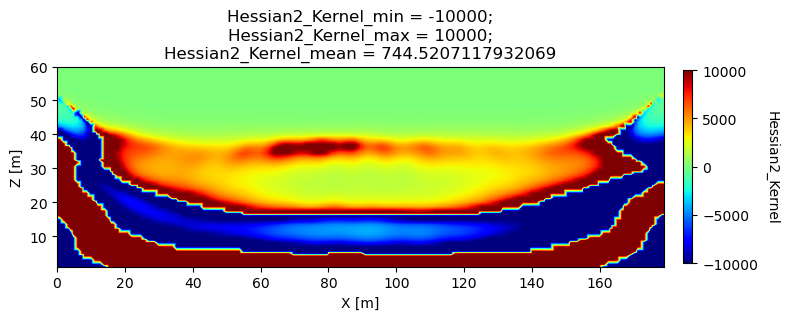

In [142]:
gradient.plot2d("Hessian2_kernel")

In [59]:
gradient.model

vp_kernel      : [[-2.2838314635009738e-06 -2.1448781808430795e-06 -1.7680882820059196e-06
  ... 7.272286666193395e-07 5.624434038509207e-07 4.900060162071895e-07]]
vs_kernel      : [[-4.272319984011119e-06 -4.626600002666237e-06 -5.399983820097987e-06
  ... 9.524074471300992e-07 5.477647846419131e-07 3.769930003727495e-07]]
Hessian1_kernel: [[448202.375 458866.53125 484242.15625 ... 521846176.0 506598336.0
  498258336.0]]
Hessian2_kernel: [[-1.9876271835528314e-05 -1.9500803318805993e-05 -1.8227645341539755e-05
  ... 3.572971763787791e-05 3.140437911497429e-05 2.9435195756377652e-05]]

In [144]:
true_model = Model(os.path.join("output", "MODEL_TRUE"))
init_model = Model(os.path.join("output", "MODEL_INIT"))
# model1 = Model(os.path.join("output", "MODEL_02"))

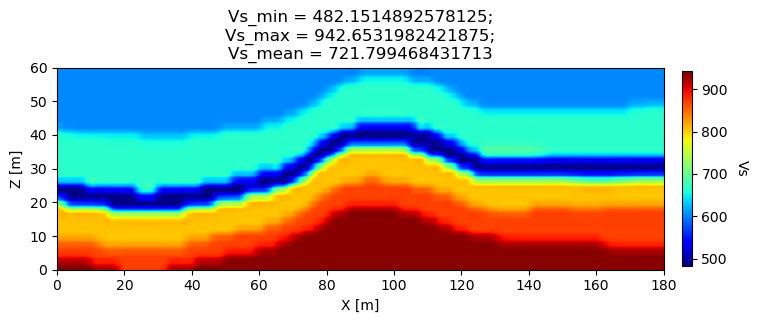

In [40]:
true_model.plot2d("vs")

In [48]:
pwd

'/csim1/zhangchang/testmodel2'

In [45]:
os.path.join(OUTPUT_path, dst + '/proc000000_x.bin')

'/csim1/zhangchang/testmodel2/output/GRADIENT_26/proc000000_x.bin'

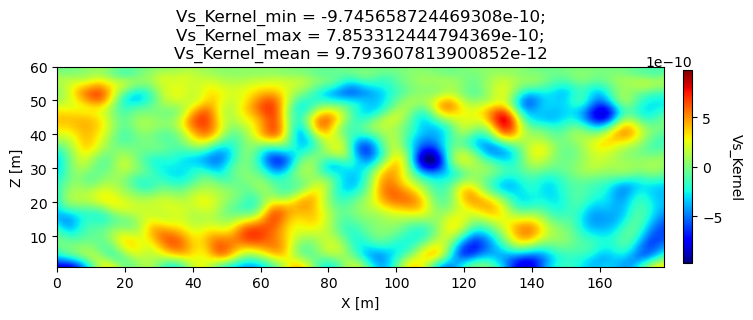

In [37]:
dst = 'GRADIENT_61'
cp(os.path.join(OUTPUT_path, 'MODEL_TRUE/proc000000_x.bin'), os.path.join(OUTPUT_path, dst + '/proc000000_x.bin'))
cp(os.path.join(OUTPUT_path, 'MODEL_TRUE/proc000000_z.bin'), os.path.join(OUTPUT_path, dst + '/proc000000_z.bin'))
model1 = Model(os.path.join("output", dst))
model1.plot2d("vs_kernel")

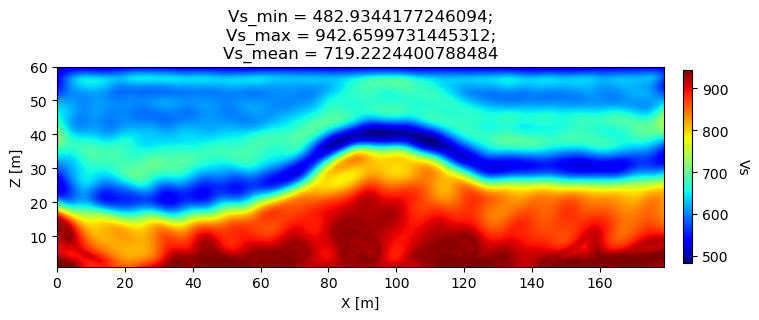

In [38]:
dst = 'MODEL_61'
cp(os.path.join(OUTPUT_path, 'MODEL_TRUE/proc000000_x.bin'), os.path.join(OUTPUT_path, dst + '/proc000000_x.bin'))
cp(os.path.join(OUTPUT_path, 'MODEL_TRUE/proc000000_z.bin'), os.path.join(OUTPUT_path, dst + '/proc000000_z.bin'))
model1 = Model(os.path.join(OUTPUT_path, dst))
model1.plot2d("vs")

In [141]:
OUTPUT_path = 'scratch/eval_grad/kernels/001'
dst = '001'
cp(os.path.join(OUTPUT_path, 'MODEL_TRUE/proc000000_x.bin'), os.path.join(OUTPUT_path, dst + '/proc000000_x.bin'))
cp(os.path.join(OUTPUT_path, 'MODEL_TRUE/proc000000_z.bin'), os.path.join(OUTPUT_path, dst + '/proc000000_z.bin'))
model1 = Model(os.path.join(OUTPUT_path, dst))
model1.plot2d("vs")

{'x': array([[0.0, 0.690692663192749, 2.0, ..., 178.0, 179.30931091308594,
         180.0]], dtype=object),
 'z': array([[0.0, 0.0, 0.0, ..., 60.0, 60.0, 60.0]], dtype=object)}

In [189]:
for a1 in dir(model1):
    exec('print("'+a1+',:"'+',model1.'+a1+')')

__class__,: <class 'seisflows.tools.model.Model'>
__delattr__,: <method-wrapper '__delattr__' of Model object at 0x797d588516d0>
__dict__,: {'path': 'output/MODEL_21', 'fmt': '.bin', 'flavor': '2D', 'model': vp: [[1883.8111572265625 1866.8175048828125 1865.536865234375 ...
  971.6095581054688 1163.61376953125 973.3311767578125]]
vs: [[940.4374389648438 941.0350952148438 941.5891723632812 ...
  439.4837646484375 429.342529296875 542.6453857421875]]
, 'regions': ['reg1', 'reg2', 'reg3'], 'coordinates': {'x': array([[0.0, 0.690692663192749, 2.0, ..., 178.0, 179.30931091308594,
        180.0]], dtype=object), 'z': array([[0.0, 0.0, 0.0, ..., 60.0, 60.0, 60.0]], dtype=object)}, '_parameters': ['vp', 'vs'], '_ngll': [16875], '_nproc': 1, 'available_parameters': ['vp', 'vs']}
__dir__,: <built-in method __dir__ of Model object at 0x797d588516d0>
__doc__,: 
    A container for reading, storing and manipulating model/gradient/kernel
    parameters from SPECFEM2D/3D/3D_GLOBE.
    Stores metadata 

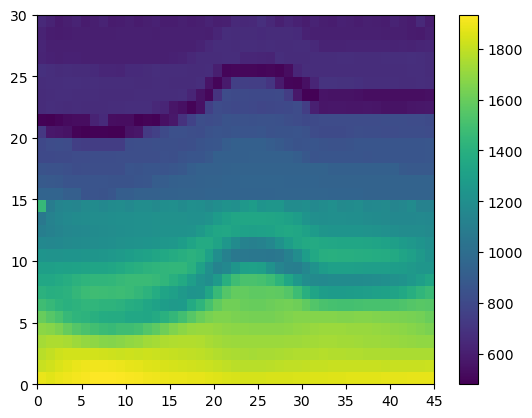

In [182]:
plt.pcolor(model1.vector.astype('float').T[::5][::5].reshape(15*2,45))
plt.colorbar()

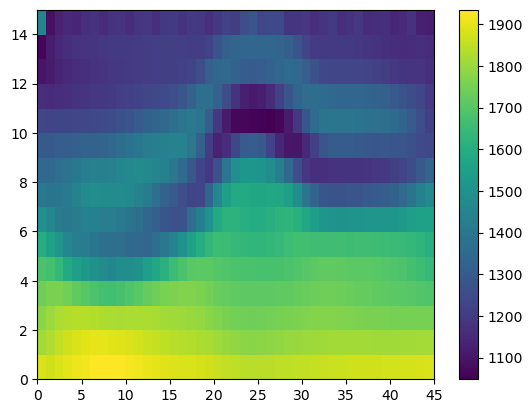

In [175]:
plt.pcolor(model1.model.vp.astype('float').T[::5][::5].reshape(15,45))
plt.colorbar()

In [57]:
import numpy as np
import pathlib

path_adj = pathlib.Path("scratch", "solver", "004", 'traces', 'adj')
adjs = sorted(path_adj.glob("*BXZ.adj"))
# print(adjs)
adjs_data = []
for adj in adjs:
    # adj
    adjs_data.append(np.loadtxt(adj)[:, 1])

adjs_data = np.array(adjs_data)
adjs_data.shape

(90, 5000)

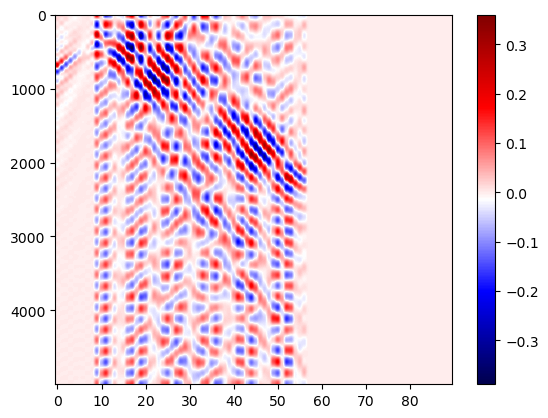

In [58]:
plt.imshow(adjs_data.T, cmap='seismic', aspect='auto')
plt.colorbar()

In [79]:
###########################

In [38]:
path_data

PosixPath('specfem2d_workdir/OUTPUT_FILES_INIT')

(90, 5000)


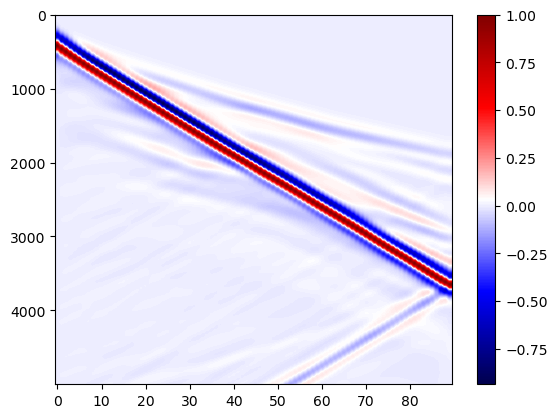

In [31]:
path_data = pathlib.Path("specfem2d_workdir", "OUTPUT_FILES_TRUE")
adjs = sorted(path_data.glob("*BXZ.semd"))

seismo_v = []
for adj in adjs:
    seismo_v.append(np.loadtxt(adj)[:, 1])

seismo_v = np.array(seismo_v)
seismo_v_init_xz = seismo_v
print(seismo_v.shape)
plt.imshow(norm_trace(seismo_v.T), cmap='seismic', aspect='auto')
plt.colorbar()

(90, 5000)


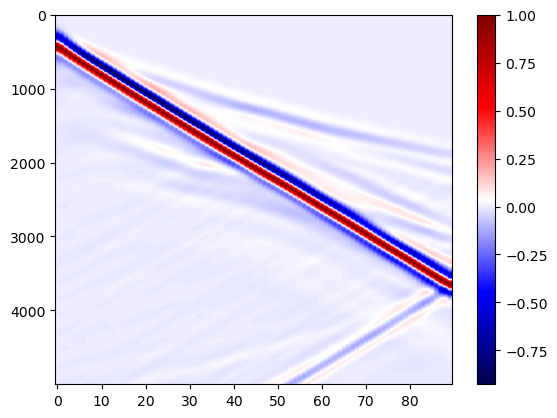

In [27]:
path_data = pathlib.Path("waveforms", "001")
adjs = sorted(path_data.glob("*BXZ.semd"))

seismo_v = []
for adj in adjs:
    seismo_v.append(np.loadtxt(adj)[:, 1])

seismo_v = np.array(seismo_v)
seismo_v_init_xz = seismo_v
print(seismo_v.shape)
plt.imshow(norm_trace(seismo_v.T), cmap='seismic', aspect='auto')
plt.colorbar()

In [28]:
pwd

'/csim1/zhangchang/testmodel'

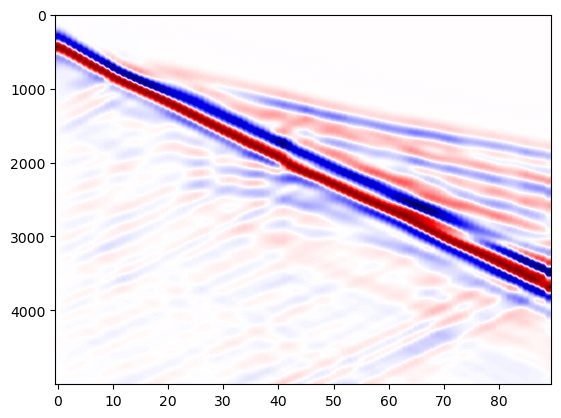

In [37]:
import numpy as np
import pathlib

path_adj = pathlib.Path("scratch", "solver", "001", 'traces', 'obs')
adjs = sorted(path_adj.glob("*BXZ.semd"))
# print(adjs)
adjs_data = []
for adj in adjs:
    # adj
    adjs_data.append(np.loadtxt(adj)[:, 1])

adjs_data = np.array(adjs_data)
adjs_data.shape
plt.imshow(norm_trace(adjs_data.T), cmap='seismic', aspect='auto')

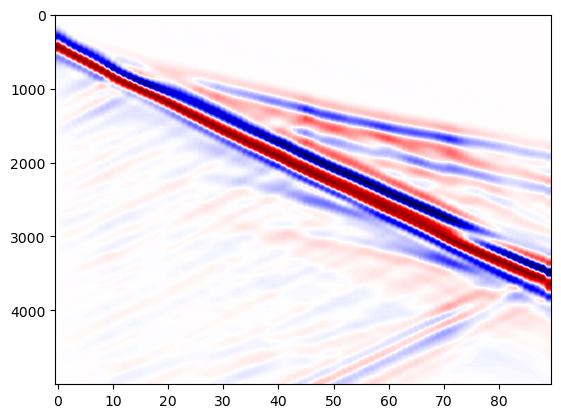

In [39]:
import numpy as np
import pathlib

path_adj = pathlib.Path("scratch", "solver", "001", 'traces', 'syn')
adjs = sorted(path_adj.glob("*BXZ.semd"))
# print(adjs)
adjs_data = []
for adj in adjs:
    # adj
    adjs_data.append(np.loadtxt(adj)[:, 1])

adjs_data = np.array(adjs_data)
adjs_data.shape
plt.imshow(norm_trace(adjs_data.T), cmap='seismic', aspect='auto')

In [49]:
import scipy.io as sio
sio.savemat('specfem_trace_layermodel_surface2.mat',{'seismo_v_true_xz':seismo_v_true_xz.T,'seismo_v_true_xx':seismo_v_true_xx.T,'seismo_v_init_xz':seismo_v_init_xz.T,'seismo_v_init_xx':seismo_v_init_xx.T})

In [210]:
path_data = pathlib.Path("dispersion")

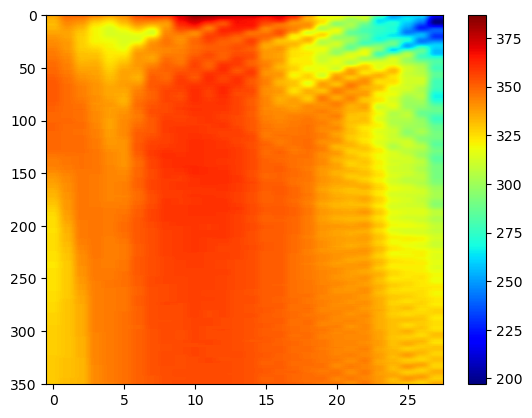

In [36]:
offset=48
side='r'
path = WORKDIR + '/dispersion'
files = sorted(glob.glob(WORKDIR + '/dispersion' + "/*"))
disp = []
files
for _disp in files[:-2]:
    _file = _disp+'/offset'+str(offset)+side+'.npy'
    # print(_file)
    if os.path.exists(_file):
        disp.append(np.load(_file))

disp = np.array(disp)
plt.imshow(disp.T, cmap='jet', aspect='auto')
plt.colorbar()

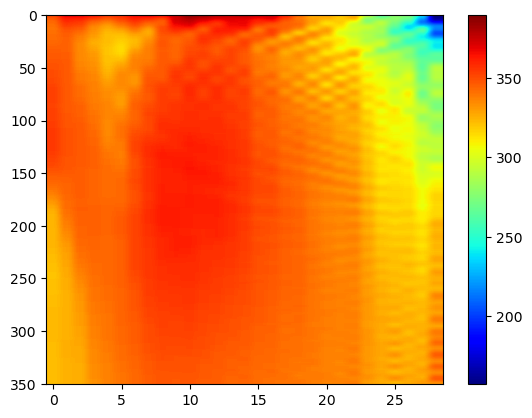

In [40]:
# /csim1/zhangchang/testmodel/scratch/solver/004/disp/syn
offset=48
side='r'
path = '/csim1/zhangchang/testmodel/scratch/solver'
files = sorted(glob.glob(path + "/*"))
disp = []
for _disp in files[:-2]:
    _file = _disp+'/disp/syn/offset'+str(offset)+side+'.npy'
    # print(_file)
    if os.path.exists(_file):
        disp.append(np.load(_file))

disp = np.array(disp)
plt.imshow(disp.T, cmap='jet', aspect='auto')
plt.colorbar()

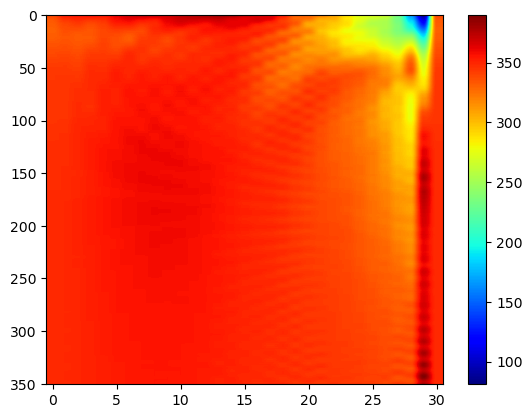

In [33]:
# /csim1/zhangchang/testmodel/scratch/solver/004/disp/syn
offset=48
side='r'
path = '/csim1/zhangchang/testmodel/scratch/solver'
files = sorted(glob.glob(path + "/*"))
disp = []
for _disp in files:
    _file = _disp+'/disp/obs/offset'+str(offset)+side+'.npy'
    # print(_file)
    if os.path.exists(_file):
        disp.append(np.load(_file))

disp = np.array(disp)
plt.imshow(disp.T, cmap='jet', aspect='auto')
plt.colorbar()

(5000, 90)


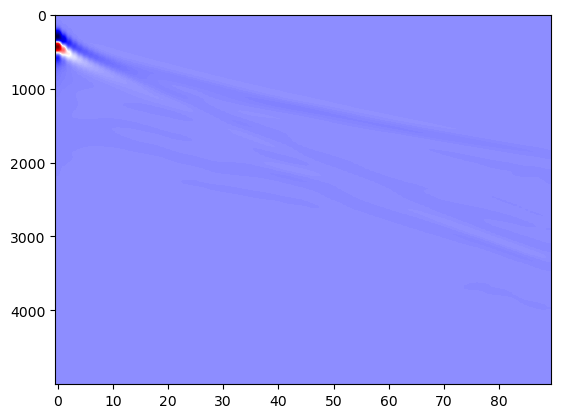

In [29]:
path_data = pathlib.Path("waveforms",'001')
adjs = sorted(path_data.glob("*BXZ.semd"))

seismo_v = []
for adj in adjs:
    seismo_v.append(np.loadtxt(adj)[:, 1])

seismo_v = np.array(seismo_v).T
print(seismo_v.shape)
seismo_v_true_xz = seismo_v
plt.imshow(norm_trace(seismo_v), cmap='seismic', aspect='auto')

In [41]:
cr_obs_r = np.zeros((351,30,16))
cr_obs_l = np.zeros((351,30,16))
path = WORKDIR + '/dispersion'
files = sorted(glob.glob(WORKDIR + '/dispersion' + "/*"))

for offset in range(48,3,-3):
    for i in range(30):
        _file = files[i]+'/offset'+str(offset)+'r.npy'
        if os.path.exists(_file):
            cr_obs_r[:,i,int(offset/3-1)] = np.load(_file)
        _file = files[i]+'/offset'+str(offset)+'l.npy'
        if os.path.exists(_file):
            cr_obs_l[:,i,int(offset/3-1)] = np.load(_file)


In [42]:
sio.savemat('simpleWDdisp.mat',{'cr_obs_r':cr_obs_r,'cr_obs_l':cr_obs_l})